### Imports and data

In [1]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats
import seaborn as sns
from cmdstanpy import CmdStanModel
from sklearn.preprocessing import StandardScaler


df = pd.read_csv("root/data/data_preprocessed/data.csv", index_col=0)


/usr/local/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


#### Checking id data is suitable for normal model

In [2]:

normality_test = stats.normaltest(np.array(df['Temperature']))

# Wyświetlanie wyników testu
print("Statystyka testu: ", normality_test.statistic)
print("Wartość p-wartości: ", normality_test.pvalue)

# Sprawdzenie interpretacji wyników testu
alpha = 0.05
if normality_test.pvalue < alpha:
    print("Dane nie pochodzą z rozkładu normalnego")
else:
    print("Dane są zgodne z rozkładem normalnym")

Statystyka testu:  3.3440751699526974
Wartość p-wartości:  0.18786388675829657
Dane są zgodne z rozkładem normalnym


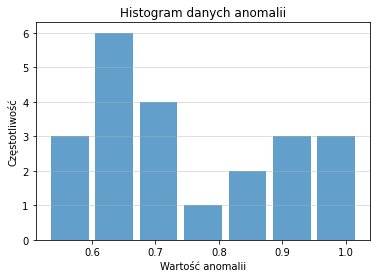

In [3]:
plt.hist(np.array(df['Temperature']), bins=7, alpha=0.7, rwidth=0.85)
plt.grid(axis='y', alpha=0.5)
plt.xlabel('Wartość anomalii')
plt.ylabel('Częstotliwość')
plt.title('Histogram danych anomalii')
plt.show()

In [4]:
df.head()

,year,CO2,CH4,N2O,Temperature
0,2001,371.319167,1771.269167,316.364167,0.54
1,2002,373.452500,1772.731667,316.942500,0.63
2,2003,375.983333,1777.334167,317.631667,0.62
3,2004,377.698333,1776.995833,318.262500,0.53
4,2005,379.983333,1774.180000,318.920000,0.68


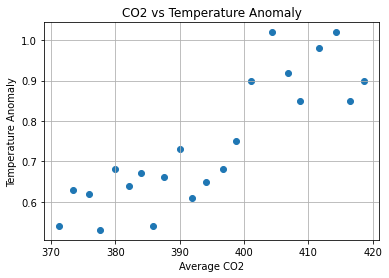

In [5]:
plt.scatter(np.array(df['CO2']), np.array(df['Temperature']))
plt.xlabel('Average CO2')
plt.ylabel('Temperature Anomaly')
plt.title('CO2 vs Temperature Anomaly')
plt.grid()
plt.show()

#### Data standarization

In [6]:
# Standaryzacja dla zmiennych CO2, CH4 i N2O
scaler = StandardScaler()
df[['CO2', 'CH4', 'N2O']] = scaler.fit_transform(df[['CO2', 'CH4', 'N2O']])

print(df)

    year       CO2       CH4       N2O  Temperature
0   2001 -1.598865 -1.102843 -1.483935         0.54
1   2002 -1.449492 -1.068258 -1.384767         0.63
2   2003 -1.272287 -0.959418 -1.266593         0.62
3   2004 -1.152206 -0.967419 -1.158423         0.53
4   2005 -0.992214 -1.034008 -1.045679         0.68
5   2006 -0.844650 -1.015326 -0.890782         0.64
6   2007 -0.709223 -0.861555 -0.782897         0.67
7   2008 -0.582723 -0.728771 -0.602136         0.54
8   2009 -0.455931 -0.575395 -0.469245         0.66
9   2010 -0.283744 -0.448149 -0.312204         0.73
10  2011 -0.161270 -0.348670 -0.137302         0.61
11  2012 -0.006880 -0.231750  0.007021         0.65
12  2013  0.180886 -0.105253  0.159489         0.68
13  2014  0.326174  0.114358  0.355969         0.75
14  2015  0.480156  0.389186  0.541731         0.90
15  2016  0.718277  0.598510  0.674336         1.02
16  2017  0.882529  0.752518  0.810657         0.92
17  2018  1.019531  0.934489  1.010995         0.85
18  2019  1.

---------------------------------------------------------------

In [7]:
df.describe()

,year,CO2,CH4,N2O,Temperature
count,22.000000,2.200000e+01,2.200000e+01,2.200000e+01,22.000000
mean,2011.500000,-2.240632e-15,1.100130e-14,-1.735985e-15,0.744091
std,6.493587,1.023533e+00,1.023533e+00,1.023533e+00,0.158284
min,2001.000000,-1.598865e+00,-1.102843e+00,-1.483935e+00,0.530000
25%,2006.250000,-8.107930e-01,-9.349521e-01,-8.638108e-01,0.632500
50%,2011.500000,-8.407511e-02,-2.902099e-01,-6.514020e-02,0.680000
75%,2016.750000,8.414658e-01,7.140160e-01,7.765772e-01,0.887500
max,2022.000000,1.709154e+00,2.224407e+00,1.825205e+00,1.020000


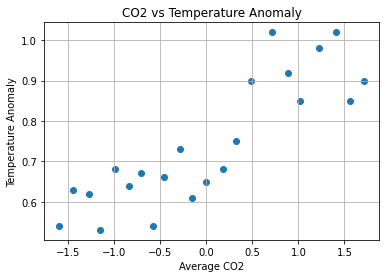

In [8]:
# Checking the impact of standarization
plt.scatter(np.array(df['CO2']), np.array(df['Temperature']))
plt.xlabel('Average CO2')
plt.ylabel('Temperature Anomaly')
plt.title('CO2 vs Temperature Anomaly')
plt.grid()
plt.show()

___________________________________________________________________________________

### 1. Model with one predictor CO2

#### 1.1. Prior predictive

In [9]:
data_sim={'N':len(df), 'CO2':np.linspace(df['CO2'].min(),df['CO2'].max(),len(df))}

In [10]:
%%writefile root/stan_files/temp1_ppc.stan
data {
  int<lower=0> N;
  vector[N] CO2;
}

generated quantities {
  real alpha = normal_rng(0.70, 0.1);
  real beta = normal_rng(0, 0.1);
  real sigma = normal_rng(0.1, 0.01);
  vector[N] temperature;

  for (i in 1:N) {
    temperature[i] = normal_rng(alpha + beta * CO2[i], sigma);
  }
}


Overwriting root/stan_files/temp1_ppc.stan


In [11]:
# 3.Simulate model
model_ppc=CmdStanModel(stan_file='root/stan_files/temp1_ppc.stan')
R = 1000
sim=model_ppc.sample(data=data_sim,
                     iter_sampling=R, 
                     iter_warmup=0, 
                     chains=1, 
                     refresh=R,
                     fixed_param=True,
                     seed=29042020)

INFO:cmdstanpy:compiling stan file /root/stan_files/temp1_ppc.stan to exe file /root/stan_files/temp1_ppc
INFO:cmdstanpy:compiled model executable: /root/stan_files/temp1_ppc
INFO:cmdstanpy:CmdStan start processing
chain 1 |██████████| 00:00 Sampling completed


INFO:cmdstanpy:CmdStan done processing.


In [12]:
# 4. Show the output
ppc_df = sim.draws_pd()
ppc_df.head()
ppc_df.describe()

,lp__,accept_stat__,alpha,beta,sigma,temperature[1],temperature[2],temperature[3],temperature[4],temperature[5],...,temperature[13],temperature[14],temperature[15],temperature[16],temperature[17],temperature[18],temperature[19],temperature[20],temperature[21],temperature[22]
count,1000.0,1000.0,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,...,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000
mean,0.0,0.0,0.702923,-0.001916,0.100123,0.702325,0.705422,0.706713,0.704241,0.700772,...,0.696007,0.705048,0.706417,0.702165,0.697680,0.702050,0.697919,0.700951,0.698552,0.707317
std,0.0,0.0,0.105269,0.098882,0.009932,0.212996,0.207510,0.191986,0.186107,0.166834,...,0.150379,0.153373,0.159595,0.167125,0.178047,0.185473,0.189024,0.197907,0.208009,0.222690
min,0.0,0.0,0.362882,-0.309225,0.068823,0.052763,0.028840,-0.044048,0.141641,0.173836,...,0.118461,0.154700,0.175342,0.084548,0.233597,0.049814,0.106479,-0.034291,0.184754,0.000117
25%,0.0,0.0,0.634950,-0.064962,0.093021,0.565634,0.568947,0.574907,0.575211,0.582583,...,0.592311,0.602847,0.602243,0.593312,0.579430,0.575676,0.567709,0.573143,0.551400,0.552435
50%,0.0,0.0,0.700385,-0.002569,0.100334,0.704046,0.700584,0.707569,0.699763,0.700044,...,0.701402,0.704084,0.704335,0.697692,0.687324,0.691344,0.697615,0.694592,0.703472,0.701917
75%,0.0,0.0,0.774480,0.070065,0.107005,0.841860,0.844404,0.840627,0.833641,0.819092,...,0.795777,0.811764,0.814706,0.818877,0.807604,0.829792,0.829456,0.835495,0.833132,0.860090
max,0.0,0.0,1.050090,0.298348,0.130075,1.361280,1.422450,1.321850,1.326300,1.138570,...,1.147370,1.253060,1.259470,1.352700,1.349570,1.366130,1.367140,1.308380,1.400830,1.391270


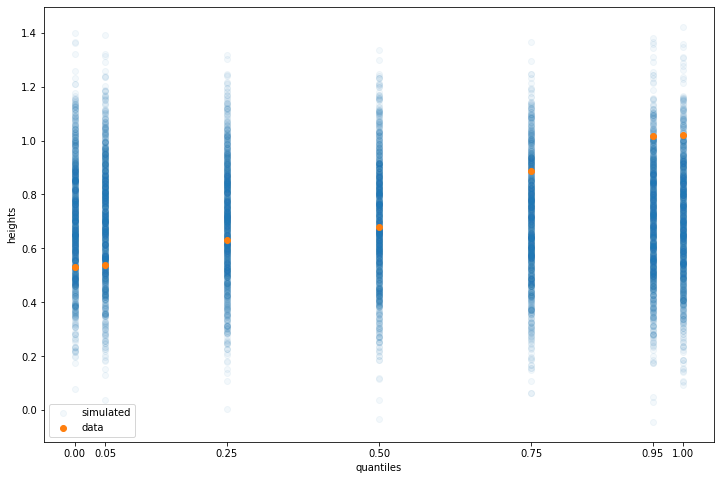

In [13]:
# 5. Plot data
temperature = ppc_df.loc[:, 'temperature[1]':'temperature[22]'].values
q = [0., 0.05, 0.25, 0.5, 0.75, 0.95, 1.]
quantiles = np.quantile(temperature, q, axis=1)
data_quantiles = np.quantile(df.Temperature, q)

plt.figure(figsize=(12, 8))
plt.scatter(q * np.ones((1000, 1)), quantiles, alpha=0.05, label='simulated')
plt.scatter(q, data_quantiles, label='data')
plt.xticks(q)
plt.xlabel('quantiles')
plt.ylabel('heights')
plt.legend()
plt.show()

#### 1.2. Fitting model to data

In [14]:

%%writefile root/stan_files/temp2_ppc.stan

data {
    int<lower=0> N;
    vector[N] temp;
    vector[N] co2;
}

parameters {
    real<lower=0> alpha;
    real<lower=0> sigma;
    real<lower=0> beta;
}

transformed parameters {
    vector[N] mean;
    for (i in 1:N) {
      mean[i] = alpha + beta * co2[i];
  }
}

model {
    alpha ~ normal(0.75, 0.1);
    sigma ~ normal(0.1, 0.01);
    beta ~ normal(0, 0.1);
    for (i in 1:N) {
      temp[i] ~ normal(mean[i], sigma);
    }
}

generated quantities {
    vector[N] temp_;
    for (i in 1:N) {
        temp_[i] = normal_rng(mean[i], sigma);
    }
}

Overwriting root/stan_files/temp2_ppc.stan


In [15]:
# 2. Create model
model_2_fit=CmdStanModel(stan_file='root/stan_files/temp2_ppc.stan')

INFO:cmdstanpy:compiling stan file /root/stan_files/temp2_ppc.stan to exe file /root/stan_files/temp2_ppc
INFO:cmdstanpy:compiled model executable: /root/stan_files/temp2_ppc


In [16]:
# 3. Prepare data for the model
N = len(df)
data_fit = {'N': N, 'co2': df.CO2.values[:N], 'temp': df.Temperature.values[:N]}

In [17]:
# 4. Simulate model
fit=model_2_fit.sample(data=data_fit,seed=28052020)

INFO:cmdstanpy:CmdStan start processing
chain 1 |          | 00:00 Status


chain 1 |██▋       | 00:00 Iteration:  400 / 2000 [ 20%]  (Warmup)


chain 1 |██████████| 00:00 Sampling completed                     
chain 2 |██████████| 00:00 Sampling completed                     
chain 3 |██████████| 00:00 Sampling completed                     
chain 4 |██████████| 00:00 Sampling completed                     

INFO:cmdstanpy:CmdStan done processing.


In [18]:
# 5. Show the output
df_ = fit.draws_pd()
df_.head()

,lp__,accept_stat__,stepsize__,treedepth__,n_leapfrog__,divergent__,energy__,alpha,sigma,beta,...,temp_[13],temp_[14],temp_[15],temp_[16],temp_[17],temp_[18],temp_[19],temp_[20],temp_[21],temp_[22]
0,35.8310,0.907518,0.861934,2.0,3.0,0.0,-34.2025,0.784779,0.099909,0.108302,...,0.710362,1.042570,0.881611,1.010250,0.911763,0.961479,0.968383,1.068350,0.940235,1.02658
1,36.9559,1.000000,0.861934,2.0,3.0,0.0,-34.9296,0.722288,0.095117,0.155785,...,0.724955,0.698372,0.992702,0.852193,0.914349,0.858641,1.004980,0.961431,1.061670,1.01238
2,36.3259,0.896811,0.861934,2.0,7.0,0.0,-35.0672,0.744433,0.112392,0.118121,...,0.644385,0.908107,0.860323,0.898182,0.919046,0.830526,0.968182,0.620446,1.042730,0.87026
3,37.0352,1.000000,0.861934,2.0,3.0,0.0,-35.8109,0.747556,0.108806,0.140054,...,0.671831,0.756331,0.693117,0.907683,1.085010,0.911013,0.988413,0.875021,1.120730,1.01416
4,37.6969,1.000000,0.861934,2.0,3.0,0.0,-36.7209,0.735277,0.085801,0.139330,...,0.747598,0.914039,0.884134,0.889638,0.878050,0.741434,0.833365,0.893841,0.929267,1.01260


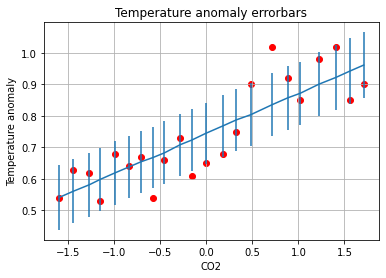

In [19]:
# 6. Plot results
temperature = df_.loc[:, 'temp_[1]':f'temp_[{N}]'].values
y = temperature.mean(axis=0)
x = data_fit['co2']
yerr = temperature.std(axis=0)

plt.errorbar(x, y, yerr)
plt.grid()
plt.scatter(x, df['Temperature'], color = 'red')
plt.xlabel('CO2')
plt.ylabel('Temperature anomaly')
plt.title('Temperature anomaly errorbars')
plt.show()

_________________________________________________________

# Predictor as three gases combined

In [33]:
%%writefile root/stan_files/temp3_ppc.stan
data {
  int<lower=0> N;
  vector[N] CO2;
  vector[N] CH4;
  vector[N] N2O;
}

generated quantities {
  real alpha = normal_rng(0.7, 0.1);
  real beta_CO2 = normal_rng(0, 0.1);
  real beta_CH4 = normal_rng(0, 0.1);
  real beta_N2O = normal_rng(0, 0.1);
  real sigma = normal_rng(0.1, 0.01);
  vector[N] temperature;

  for (i in 1:N) {
    temperature[i] = normal_rng(alpha + beta_CO2 * CO2[i] + beta_CH4 *CH4[i] +beta_N2O*N2O[i], sigma);
  }
}


Overwriting root/stan_files/temp3_ppc.stan


In [34]:
data_sim={'N':len(df), 'CO2':np.linspace(df.CO2.min(),df.CO2.max(),len(df)),'CH4':np.linspace(df.CH4.min(),df.CH4.max(),len(df)),'N2O':np.linspace(df.N2O.min(),df.N2O.max(),len(df))}
df.head()
model_ppc2=CmdStanModel(stan_file='root/stan_files/temp3_ppc.stan')
R = 1000
sim=model_ppc2.sample(data=data_sim,
                     iter_sampling=R, 
                     iter_warmup=0, 
                     chains=1, 
                     refresh=R,
                     fixed_param=True,
                     seed=29042020)
ppc_df = sim.draws_pd()
ppc_df.head()
ppc_df = sim.draws_pd()
ppc_df.describe()

INFO:cmdstanpy:compiling stan file /root/stan_files/temp3_ppc.stan to exe file /root/stan_files/temp3_ppc
INFO:cmdstanpy:compiled model executable: /root/stan_files/temp3_ppc
INFO:cmdstanpy:CmdStan start processing
chain 1 |██████████| 00:00 Sampling completed


INFO:cmdstanpy:CmdStan done processing.


,lp__,accept_stat__,alpha,beta_CO2,beta_CH4,beta_N2O,sigma,temperature[1],temperature[2],temperature[3],...,temperature[13],temperature[14],temperature[15],temperature[16],temperature[17],temperature[18],temperature[19],temperature[20],temperature[21],temperature[22]
count,1000.0,1000.0,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,...,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000
mean,0.0,0.0,0.701682,-0.000416,-0.003484,-0.001581,0.100105,0.710969,0.710432,0.707001,...,0.695815,0.695222,0.700663,0.696462,0.696554,0.694410,0.694310,0.690450,0.689866,0.685975
std,0.0,0.0,0.102247,0.104409,0.099558,0.098230,0.009737,0.293092,0.271775,0.252820,...,0.173987,0.187284,0.206124,0.224548,0.243305,0.267407,0.290286,0.317786,0.346725,0.368433
min,0.0,0.0,0.410646,-0.307990,-0.311771,-0.276868,0.072005,-0.293899,-0.160189,-0.166903,...,-0.137570,0.149061,0.072888,-0.041836,-0.010498,-0.146661,-0.296827,-0.396585,-0.474077,-0.444598
25%,0.0,0.0,0.633142,-0.069758,-0.071081,-0.066732,0.093648,0.511189,0.522889,0.535858,...,0.575644,0.565377,0.552836,0.542641,0.525193,0.512779,0.495001,0.476194,0.453242,0.448840
50%,0.0,0.0,0.699878,-0.002746,-0.001863,-0.005357,0.100530,0.710422,0.715670,0.717235,...,0.700900,0.694741,0.699154,0.694723,0.701631,0.700727,0.690840,0.697058,0.692617,0.675412
75%,0.0,0.0,0.776852,0.072819,0.064801,0.066223,0.106178,0.909640,0.890691,0.877258,...,0.807554,0.821578,0.836153,0.844427,0.863325,0.885511,0.887964,0.899412,0.931374,0.934493
max,0.0,0.0,0.990576,0.327453,0.264898,0.310860,0.133609,1.571810,1.550640,1.563280,...,1.284090,1.298470,1.323250,1.347750,1.443850,1.555480,1.617090,1.732420,1.803050,1.727650


(array([ 10.,  32.,  89., 177., 241., 201., 153.,  67.,  25.,   5.]),
 array([-0.30799  , -0.2444457, -0.1809014, -0.1173571, -0.0538128,
         0.0097315,  0.0732758,  0.1368201,  0.2003644,  0.2639087,
         0.327453 ]),
 <BarContainer object of 10 artists>)

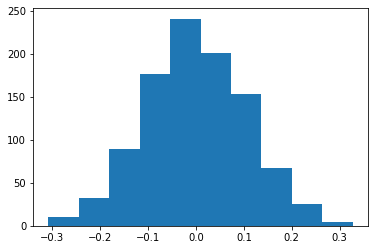

In [35]:
plt.hist(ppc_df['beta_CO2'])

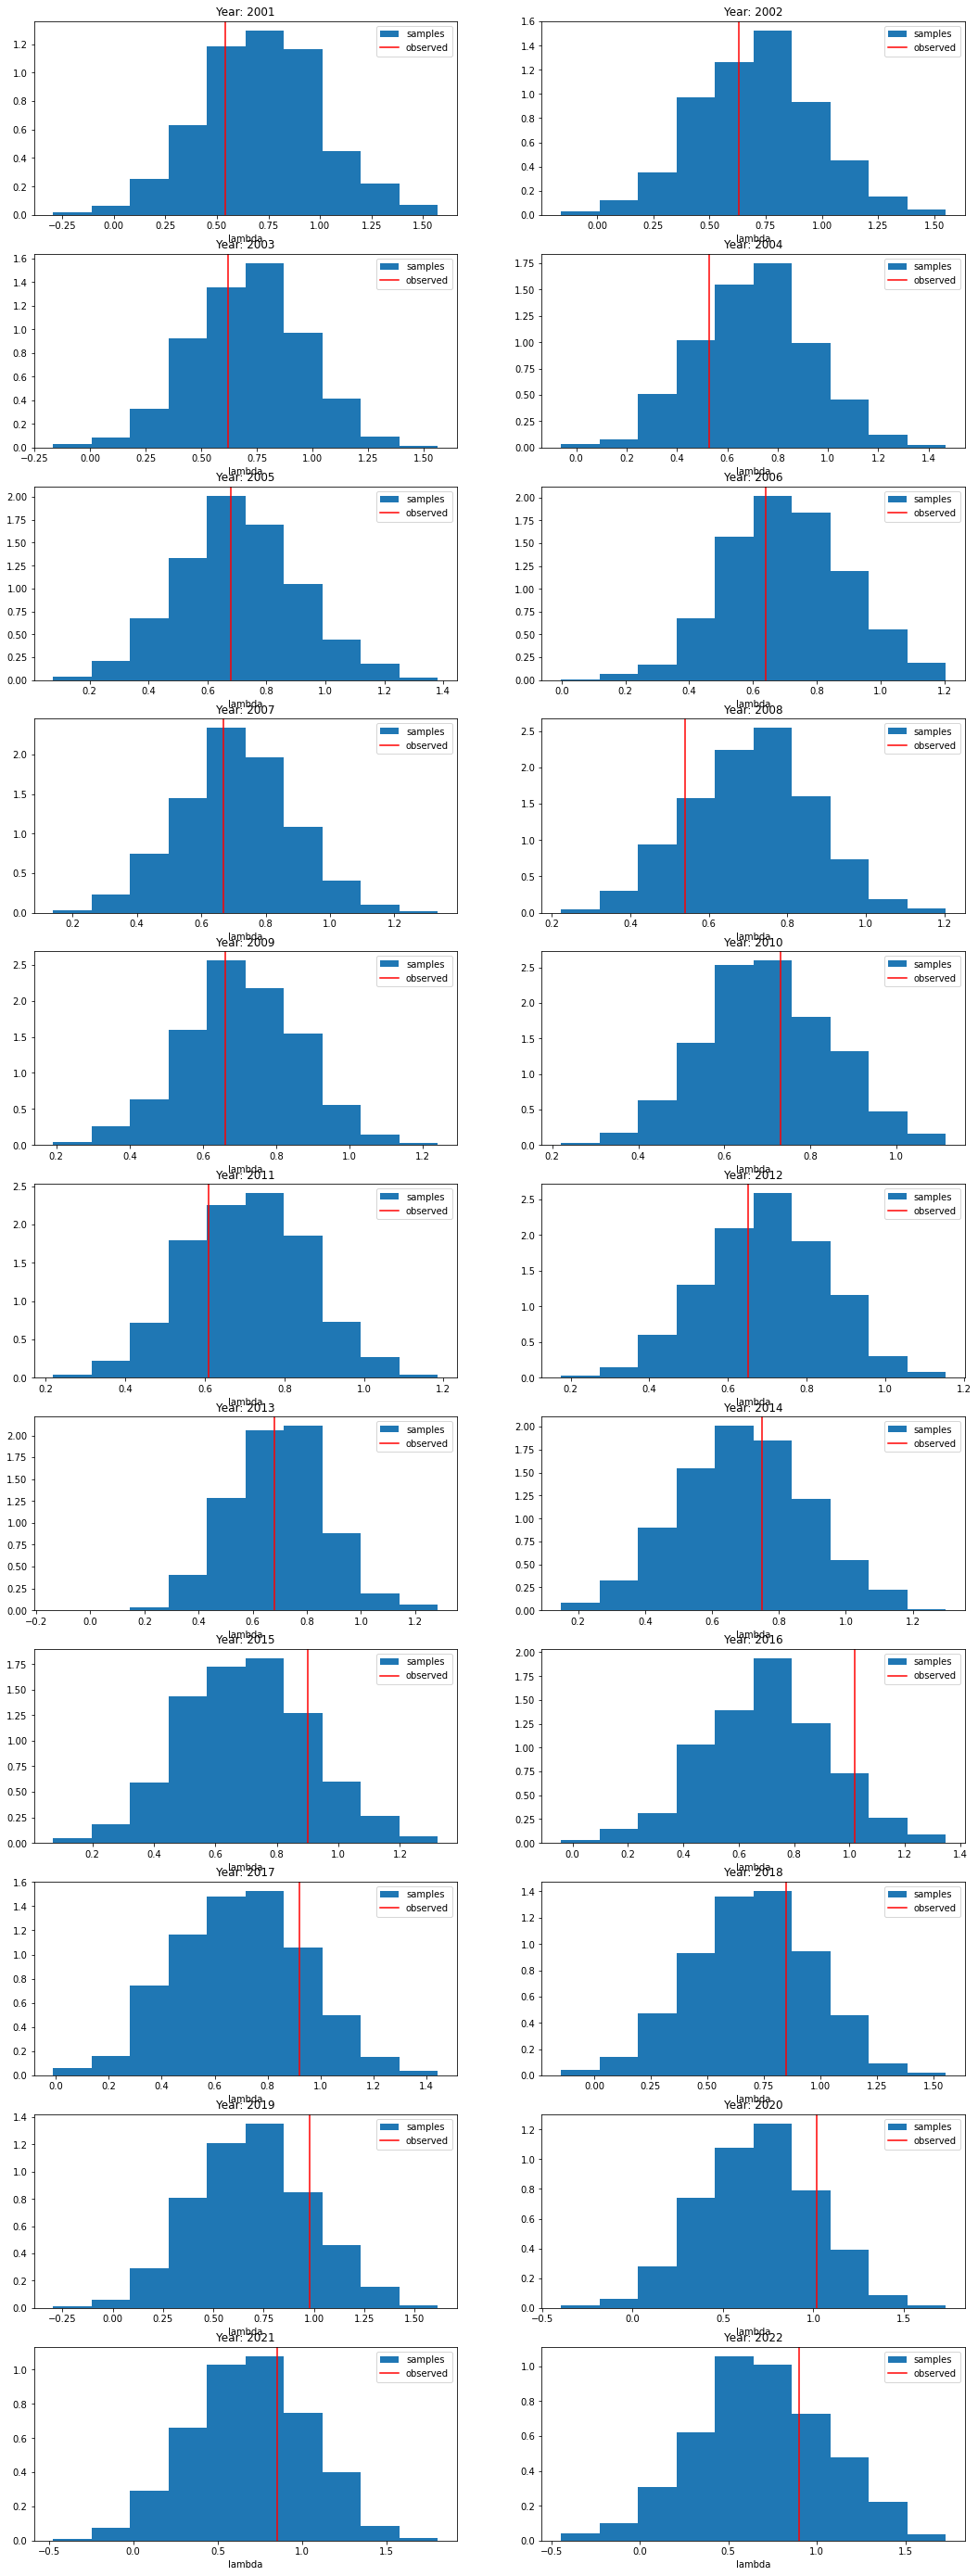

In [36]:
fig, axes = plt.subplots(int(len(df)/2), 2, figsize=(18, 50))
axes = axes.flatten()

sampled_lambdas = ppc_df.loc[:, "temperature[1]":"temperature[22]"]
observed_lambda = df['Temperature'].values
for i, ax in enumerate(axes):
    ax.hist(sampled_lambdas[f'temperature[{i + 1}]'].values, density=True, label='samples')
    ax.axvline(x=observed_lambda[i], color='r', label='observed')
    ax.set_xlabel('lambda')
    ax.set_title(f'Year: {df["year"][i]}')
    ax.legend()

Text(80, 20, 'min')

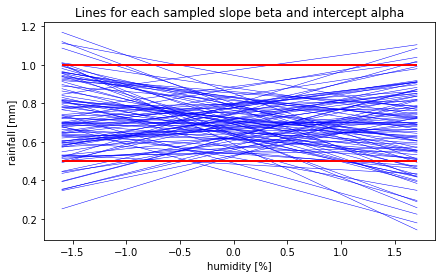

In [37]:
fig, axes = plt.subplots(1,1,figsize=(7,4))

beta_humid = sim.stan_variable('beta_CO2')
alpha_humid = sim.stan_variable('alpha')
for i in range(100):
    axes.plot(df['CO2'], alpha_humid[i]+beta_humid[i]*np.array(df['CO2']), linewidth = 0.5, color='b')
plt.title("Lines for each sampled slope beta and intercept alpha")
axes.set_xlabel('humidity [%]')
axes.set_ylabel('rainfall [mm]')
axes.hlines([0.5, 1],xmin = df['CO2'].min(), xmax = df['CO2'].max(), linestyles = '-',linewidth = 2, color = 'r')
axes.annotate(text='max',xy=(80,320), weight = 'bold', color = 'r', fontsize = 15)
axes.annotate(text='min',xy=(80,20), weight = 'bold', color = 'r', fontsize = 15)

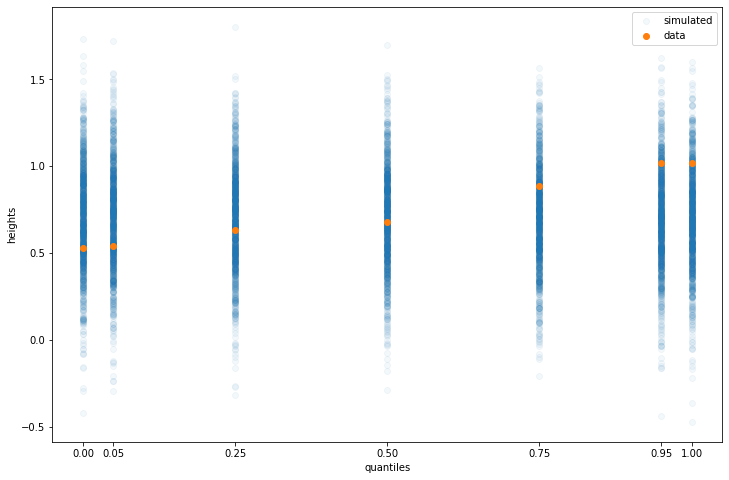

In [38]:
temperature = ppc_df.loc[:, 'temperature[1]':'temperature[22]'].values
q = [0., 0.05, 0.25, 0.5, 0.75, 0.95, 1.]
quantiles = np.quantile(temperature, q, axis=1)
data_quantiles = np.quantile(df.Temperature, q)

plt.figure(figsize=(12, 8))
plt.scatter(q * np.ones((1000, 1)), quantiles, alpha=0.05, label='simulated')
plt.scatter(q, data_quantiles, label='data')
plt.xticks(q)
plt.xlabel('quantiles')
plt.ylabel('heights')
plt.legend()
plt.show()

##### Fitting model to data

In [39]:
%%writefile root/stan_files/temp4_ppc.stan

data {
    int<lower=0> N;
    vector[N] temp;
    vector[N] CO2;
    vector[N] CH4;
    vector[N] N2O;
}

parameters {
    real<lower=0> alpha;
    real<lower=0> sigma;
    real<lower=0> beta_CO2;
    real<lower=0> beta_CH4;
    real<lower=0> beta_N2O;
}

transformed parameters {
    vector[N] mean;
    for (i in 1:N) {
        mean[i] = alpha + beta_CO2 * CO2[i] + beta_CH4 * CH4[i] + beta_N2O * N2O[i];
    }
}

model {
    alpha ~ normal(0.70, 0.05);
    sigma ~ normal(0.1, 0.01);
    beta_CO2 ~ normal(0, 1);
    beta_CH4 ~ normal(0, 1);
    beta_N2O ~ normal(0, 1);
    for (i in 1:N) {
        temp[i] ~ normal(mean[i], sigma);
    }
}

generated quantities {
    vector[N] temp_;
    real log_lik[N];
    for (i in 1:N) {
        temp_[i] = normal_rng(mean[i], sigma);
        log_lik[i] = normal_lpdf(temp_[i] | mean[i], sigma);
    }
}


Overwriting root/stan_files/temp4_ppc.stan


In [40]:
model_2_fit=CmdStanModel(stan_file='root/stan_files/temp4_ppc.stan')

INFO:cmdstanpy:compiling stan file /root/stan_files/temp4_ppc.stan to exe file /root/stan_files/temp4_ppc
INFO:cmdstanpy:compiled model executable: /root/stan_files/temp4_ppc
--- Translating Stan model to C++ code ---
bin/stanc  --o=/root/stan_files/temp4_ppc.hpp /root/stan_files/temp4_ppc.stan
Warning in '/root/stan_files/temp4_ppc.stan', line 38, column 4: Declaration
    of arrays by placing brackets after a variable name is deprecated and
    will be removed in Stan 2.32.0. Instead use the array keyword before the
    type. This can be changed automatically using the auto-format flag to
    stanc

--- Compiling, linking C++ code ---
g++ -std=c++1y -pthread -D_REENTRANT -Wno-sign-compare -Wno-ignored-attributes      -I stan/lib/stan_math/lib/tbb_2020.3/include    -O3 -I src -I stan/src -I lib/rapidjson_1.1.0/ -I lib/CLI11-1.9.1/ -I stan/lib/stan_math/ -I stan/lib/stan_math/lib/eigen_3.3.9 -I stan/lib/stan_math/lib/boost_1.75.0 -I stan/lib/stan_math/lib/sundials_6.0.0/include -I stan

In [41]:
N = len(df)
data_fit = {'N': N, 'CO2': df.CO2.values[:N], 'temp': df.Temperature.values[:N], 'CH4': df.CH4.values[:N], 'N2O': df.N2O.values[:N]}

In [42]:
fit=model_2_fit.sample(data=data_fit,seed=28052020)

INFO:cmdstanpy:CmdStan start processing
chain 1 |          | 00:00 Status




chain 1 |█▎        | 00:00 Iteration:  100 / 2000 [  5%]  (Warmup)


chain 1 |██████▎   | 00:00 Iteration: 1100 / 2000 [ 55%]  (Sampling)


chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


INFO:cmdstanpy:CmdStan done processing.


In [43]:
df_ = fit.draws_pd()
df_.head()
df_.describe()

,lp__,accept_stat__,stepsize__,treedepth__,n_leapfrog__,divergent__,energy__,alpha,sigma,beta_CO2,...,log_lik[13],log_lik[14],log_lik[15],log_lik[16],log_lik[17],log_lik[18],log_lik[19],log_lik[20],log_lik[21],log_lik[22]
count,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.0,4000.000000,4000.000000,4000.000000,4000.000000,...,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000
mean,28.816448,0.917795,0.170263,4.070500,21.435000,0.0,-26.294178,0.737839,0.096041,0.049947,...,0.918630,0.909671,0.918460,0.918056,0.901661,0.916586,0.929640,0.916238,0.933086,0.944162
std,1.732600,0.140510,0.030290,0.716351,9.069914,0.0,2.346127,0.018835,0.008960,0.033482,...,0.718536,0.718012,0.749618,0.746825,0.747080,0.732367,0.702064,0.739278,0.709938,0.675311
min,18.706500,0.000172,0.128688,1.000000,1.000000,0.0,-31.218900,0.672493,0.069623,0.000035,...,-5.434730,-5.844970,-5.251960,-4.805160,-5.486350,-5.063800,-6.887560,-5.078380,-5.593240,-5.346250
25%,27.919250,0.911112,0.148664,4.000000,15.000000,0.0,-28.009300,0.725110,0.089903,0.022357,...,0.734818,0.716492,0.764162,0.766373,0.738279,0.749649,0.755886,0.745362,0.772170,0.775035
50%,29.174600,0.970817,0.173046,4.000000,15.000000,0.0,-26.610400,0.737569,0.095776,0.044914,...,1.185310,1.185480,1.185385,1.185765,1.168255,1.176715,1.181430,1.182540,1.184570,1.187875
75%,30.094050,0.992537,0.194646,5.000000,31.000000,0.0,-24.970150,0.750310,0.102192,0.073287,...,1.355540,1.355085,1.355795,1.362427,1.354958,1.361620,1.360975,1.363165,1.360008,1.358413
max,31.482500,1.000000,0.206273,5.000000,63.000000,0.0,-14.271700,0.802687,0.128472,0.177312,...,1.744590,1.729760,1.726560,1.731580,1.679100,1.737880,1.727500,1.699570,1.735050,1.737290


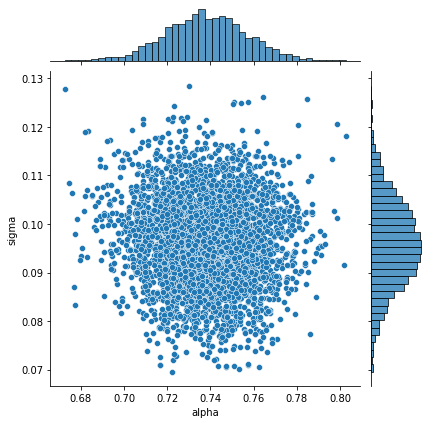

In [44]:
sns.jointplot(data=df_, x='alpha', y='sigma')

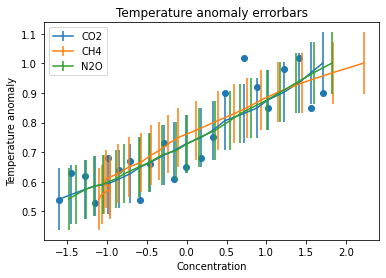

In [45]:
temperature = df_.loc[:, 'temp_[1]':f'temp_[{N}]'].values
y = temperature.mean(axis=0)
x_CO2 = data_fit['CO2']
x_CH4 = data_fit['CH4']
x_N2O = data_fit['N2O']
yerr = temperature.std(axis=0)

# Wykres
plt.errorbar(x_CO2, y, yerr, label='CO2')
plt.errorbar(x_CH4, y, yerr, label='CH4')
plt.errorbar(x_N2O, y, yerr, label='N2O')
plt.scatter(x_CO2, df['Temperature'])
plt.xlabel('Concentration')
plt.ylabel('Temperature anomaly')
plt.title('Temperature anomaly errorbars')
plt.legend()
plt.show()

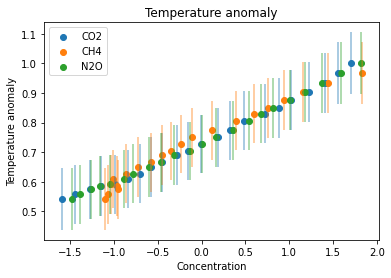

In [46]:
temperature = df_.loc[:, 'temp_[1]':f'temp_[{N}]'].values
y = temperature.mean(axis=0)
x_CO2 = data_fit['CO2']
x_CH4 = data_fit['CH4']
x_N2O = data_fit['N2O']
yerr = temperature.std(axis=0)

# Calculate the spacing between the dots
spacing = 0.2  # Adjust this value to control the spacing

# Plot scatter plot with error bars
plt.scatter(x_CO2, y, label='CO2')
plt.scatter(x_CH4, y, label='CH4')
plt.scatter(x_N2O, y, label='N2O')

# Add error bar spaces
plt.errorbar(x_CO2, y, yerr, linestyle='None', alpha=0.5)
plt.errorbar(x_CH4, y, yerr, linestyle='None', alpha=0.5)
plt.errorbar(x_N2O, y, yerr, linestyle='None', alpha=0.5)

# Adjust x-axis limits to show error bars
plt.xlim(min(x_CO2) - spacing, max(x_N2O) + spacing)

plt.xlabel('Concentration')
plt.ylabel('Temperature anomaly')
plt.title('Temperature anomaly')
plt.legend()
plt.show()


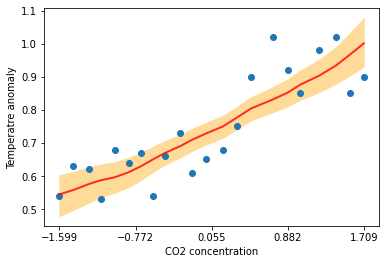

In [47]:
import matplotlib as mpl

x = np.array(df['CO2'])
mu = fit.stan_variable('mean')


fig, ax = plt.subplots(1,1)
# plot scatterplot and lines
ax.fill_between(
    x,
    np.percentile(mu, 5, axis=0),
    np.percentile(mu, 95, axis=0),
    color=1-0.4*(1-np.array(mpl.colors.to_rgb('orange')))
)
ax.plot(
    x,
    np.percentile(mu, 50, axis=0),
    color='red',
    linewidth=2,
    alpha=0.8
)
ax.scatter(x,df['Temperature'])
ax.set_xlabel('CO2 concentration')
ax.set_ylabel("Temperatre anomaly")
ax.set_xticks(np.linspace(x.min(), x.max(),5))



In [161]:
df_

,lp__,accept_stat__,stepsize__,treedepth__,n_leapfrog__,divergent__,energy__,alpha,sigma,beta_CO2,...,temp_[13],temp_[14],temp_[15],temp_[16],temp_[17],temp_[18],temp_[19],temp_[20],temp_[21],temp_[22]
0,29.7443,0.942615,0.171458,4.0,15.0,0.0,-28.4576,0.721763,0.097235,0.058722,...,0.841310,0.935051,0.853431,0.643023,0.707723,0.782686,0.979988,0.910048,0.916083,0.930553
1,28.8341,0.964319,0.171458,5.0,31.0,0.0,-26.6891,0.738870,0.096443,0.016683,...,0.617850,0.648305,0.859719,0.866198,0.700646,0.764680,1.022600,0.893439,0.953276,1.205000
2,27.5734,0.922527,0.171458,3.0,11.0,0.0,-24.8830,0.715327,0.089955,0.008497,...,0.643954,0.760654,0.976726,0.779189,0.749559,1.016390,0.772382,0.982979,0.979143,0.901167
3,26.0286,0.867597,0.171458,4.0,15.0,0.0,-23.5337,0.713108,0.110809,0.007818,...,0.594226,0.742247,0.762340,0.557638,0.469533,0.834067,0.789872,0.791779,1.041400,0.889362
4,25.2429,0.996878,0.171458,5.0,31.0,0.0,-22.1095,0.773922,0.089036,0.086780,...,0.879104,0.960186,0.615110,0.886212,0.894023,0.724619,0.840401,0.960534,0.767012,0.804117
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3995,30.0730,0.993356,0.183366,5.0,31.0,0.0,-29.5549,0.746468,0.092524,0.097219,...,0.795187,0.859179,0.875177,0.733377,0.897962,0.828046,1.047710,0.924374,0.967418,0.941876
3996,29.5021,0.814324,0.183366,4.0,31.0,0.0,-27.9218,0.727854,0.091319,0.023892,...,0.841471,0.932752,0.855741,0.831259,0.894857,0.668470,0.943141,0.844809,0.970135,0.931256
3997,27.5588,0.990318,0.183366,4.0,15.0,0.0,-26.1997,0.732343,0.114518,0.097606,...,0.906283,0.924671,0.758234,0.772567,0.828793,0.841310,0.751221,0.880889,1.006640,1.108170
3998,28.7712,0.976136,0.183366,4.0,15.0,0.0,-26.3619,0.740654,0.103262,0.047376,...,0.714770,0.803772,0.675052,0.901817,0.888225,0.883111,0.920684,0.943875,0.848672,0.975379


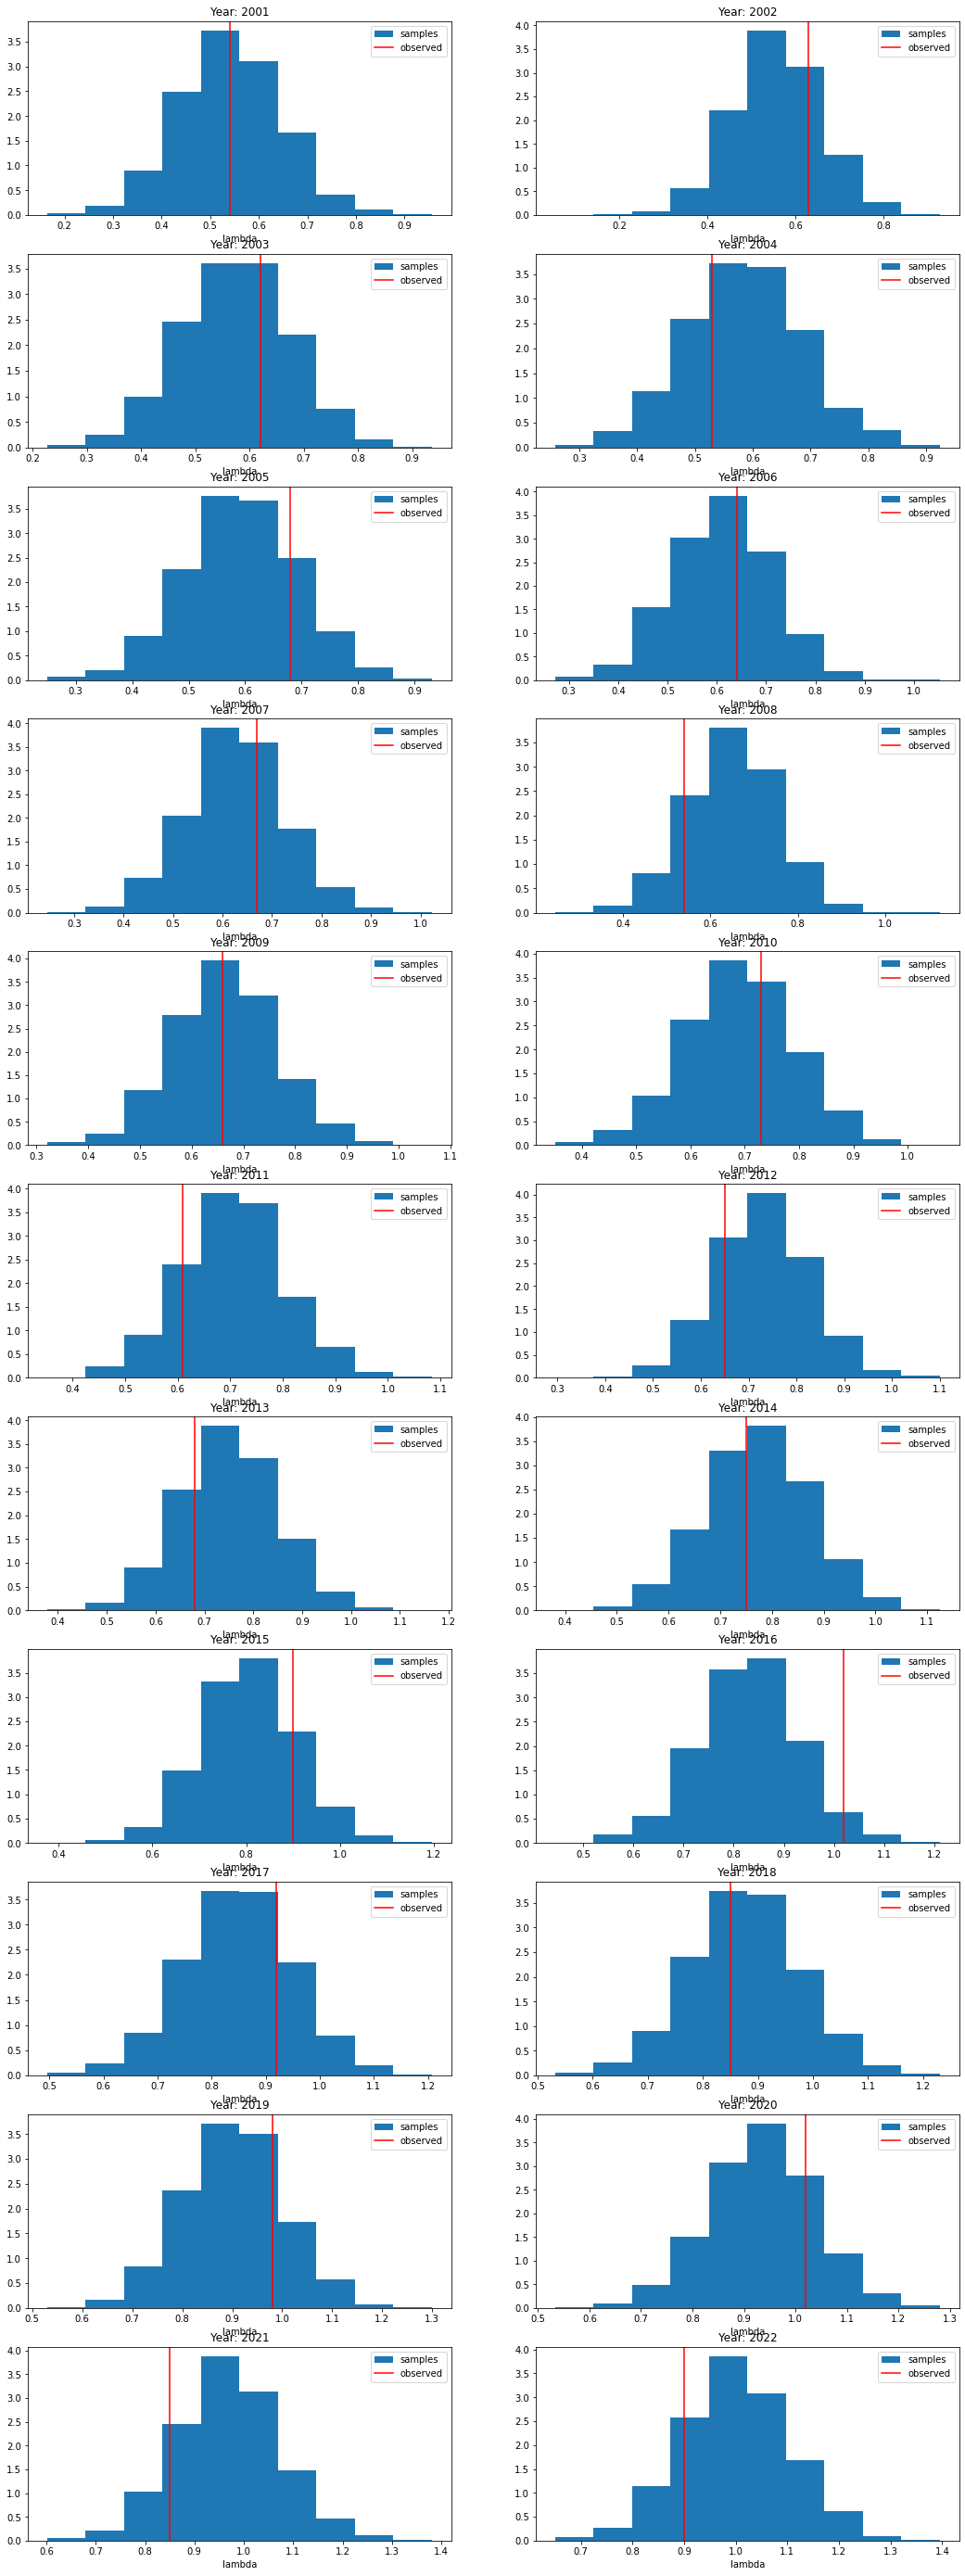

In [48]:
fig, axes = plt.subplots(int(len(df)/2), 2, figsize=(18, 50))
axes = axes.flatten()

sampled_lambdas = df_.loc[:, "temp_[1]":"temp_[22]"]
observed_lambda = df['Temperature'].values
for i, ax in enumerate(axes):
    ax.hist(sampled_lambdas[f'temp_[{i + 1}]'].values, density=True, label='samples')
    ax.axvline(x=observed_lambda[i], color='r', label='observed')
    ax.set_xlabel('lambda')
    ax.set_title(f'Year: {df["year"][i]}')
    ax.legend()

________________________________________________________

### Different alphas for every year

In [49]:
%%writefile root/stan_files/temp5_ppc.stan

data {
    int<lower=0> N;
    vector[N] temp;
    vector[N] CO2;
    vector[N] CH4;
    vector[N] N2O;
}

parameters {
    real<lower=0> alpha[N];
    real<lower=0> sigma;
    real<lower=0> beta_CO2;
    real<lower=0> beta_CH4;
    real<lower=0> beta_N2O;
}

transformed parameters {
    vector[N] mean;
    for (i in 1:N) {
        mean[i] = alpha[i] + beta_CO2 * CO2[i] + beta_CH4 * CH4[i] + beta_N2O * N2O[i];
    }
}

model {
    alpha ~ normal(0.70, 0.05);
    sigma ~ normal(0.1, 0.01);
    beta_CO2 ~ normal(0, 0.1);
    beta_CH4 ~ normal(0, 0.1);
    beta_N2O ~ normal(0, 0.1);
    for (i in 1:N) {
        temp[i] ~ normal(mean[i], sigma);
    }
}

generated quantities {
    vector[N] temp_;
    real log_lik[N];
    for (i in 1:N) {
        temp_[i] = normal_rng(mean[i], sigma);
        log_lik[i] = normal_lpdf(temp_[i] | mean[i], sigma);
    }
}


Overwriting root/stan_files/temp5_ppc.stan


In [50]:
model_3_fit=CmdStanModel(stan_file='root/stan_files/temp5_ppc.stan')
N = len(df)
data_fit = {'N': N, 'CO2': df.CO2.values[:N], 'temp': df.Temperature.values[:N], 'CH4': df.CH4.values[:N], 'N2O': df.N2O.values[:N]}
fit=model_3_fit.sample(data=data_fit,seed=28052020)
df_fit = fit.draws_pd()

INFO:cmdstanpy:compiling stan file /root/stan_files/temp5_ppc.stan to exe file /root/stan_files/temp5_ppc
INFO:cmdstanpy:compiled model executable: /root/stan_files/temp5_ppc
--- Translating Stan model to C++ code ---
bin/stanc  --o=/root/stan_files/temp5_ppc.hpp /root/stan_files/temp5_ppc.stan
Warning in '/root/stan_files/temp5_ppc.stan', line 11, column 4: Declaration
    of arrays by placing brackets after a variable name is deprecated and
    will be removed in Stan 2.32.0. Instead use the array keyword before the
    type. This can be changed automatically using the auto-format flag to
    stanc
Warning in '/root/stan_files/temp5_ppc.stan', line 38, column 4: Declaration
    of arrays by placing brackets after a variable name is deprecated and
    will be removed in Stan 2.32.0. Instead use the array keyword before the
    type. This can be changed automatically using the auto-format flag to
    stanc

--- Compiling, linking C++ code ---
g++ -std=c++1y -pthread -D_REENTRANT -Wno-s

INFO:cmdstanpy:CmdStan done processing.


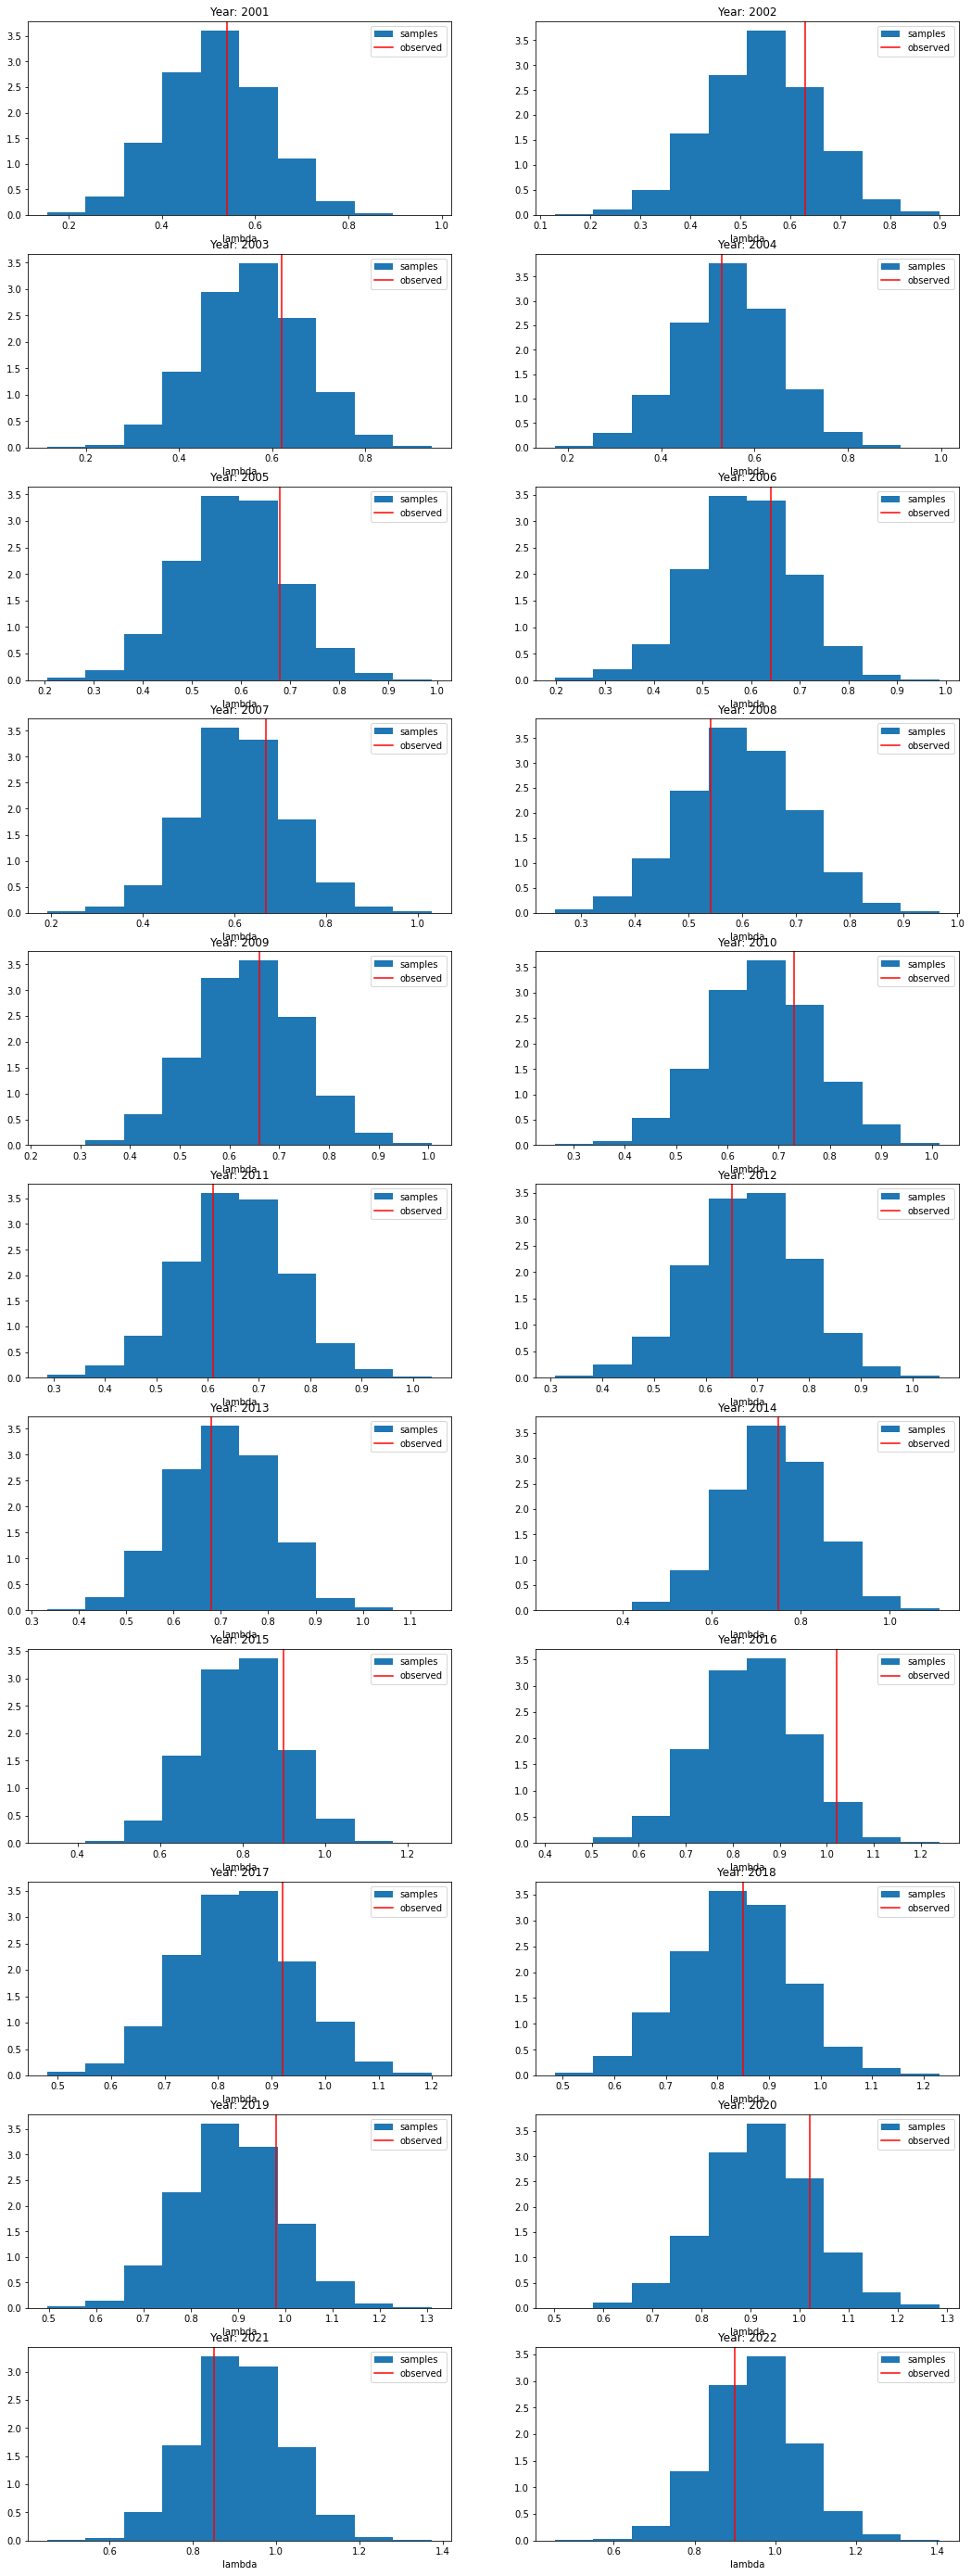

In [51]:
fig, axes = plt.subplots(int(len(df)/2), 2, figsize=(18, 50))
axes = axes.flatten()

sampled_lambdas = df_fit.loc[:, "temp_[1]":"temp_[22]"]
observed_lambda = df['Temperature'].values
for i, ax in enumerate(axes):
    ax.hist(sampled_lambdas[f'temp_[{i + 1}]'].values, density=True, label='samples')
    ax.axvline(x=observed_lambda[i], color='r', label='observed')
    ax.set_xlabel('lambda')
    ax.set_title(f'Year: {df["year"][i]}')
    ax.legend()

______________________________________________________________________

________________________________________________